# A few tips to get started with homework 3

This will illustrate how to use [pandas](https://pandas.pydata.org) to read a text file.

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
def parse_dates(df):
    """ parses date columns on a dataframe to a datetime object
    """
    times = []
    for i in range(len(df.index)):
        times.append(datetime.datetime(int(df.loc[i]['#YY']), int(df.loc[i]['MM']),
                                       int(df.loc[i]['DD']), int(df.loc[i]['hh']),
                                       int(df.loc[i]['mm'])))
    df.drop(columns=['#YY', 'MM', 'DD', 'hh', 'mm'], inplace=True)
    df['time'] = times
    df.set_index('time', inplace=True)
    return df

In [3]:
files = sorted(glob.glob('../../data/NDBC/*.txt')) # change this to the path of your .txt NDBC files
columns_to_use = ['#YY', 'MM', 'DD', 'hh', 'mm', 'ATMP', 'WSPD', 'WVHT', 'WTMP'] # select only what we need
tmp = []
for f in files: # Now we will concatenate the 3 files together
    df = pd.read_csv(f, skiprows=[1,2], sep=r"[ ]{1,}", engine='python', usecols=columns_to_use)
    tmp.append(parse_dates(df))
    print('processed file: %s' %f)
df = pd.concat(tmp)

processed file: ../../data/NDBC/46001h2016.txt
processed file: ../../data/NDBC/46001h2017.txt
processed file: ../../data/NDBC/46001h2018.txt


In [4]:
df.head()

,WSPD,WVHT,ATMP,WTMP
time,,,,
2016-01-01 00:50:00,12.9,3.71,5.1,5.9
2016-01-01 01:50:00,14.7,4.18,4.0,5.9
2016-01-01 02:50:00,12.6,4.08,5.1,5.9
2016-01-01 03:50:00,10.9,4.53,6.3,5.9
2016-01-01 04:50:00,8.7,4.62,6.4,5.9


In [5]:
df.describe() # One of the beauties of pandas

,WSPD,WVHT,ATMP,WTMP
count,26246.000000,26246.000000,26246.000000,26246.000000
mean,7.571409,2.703506,7.807113,9.037743
std,3.623396,3.905997,9.484474,19.639652
min,0.000000,0.420000,-5.900000,4.100000
25%,5.100000,1.560000,4.900000,5.500000
50%,7.200000,2.260000,6.700000,7.700000
75%,9.700000,3.280000,11.200000,11.800000
max,99.000000,99.000000,999.000000,999.000000


It looks like bad data are flagged with 999 or 99, so let's take that out.

In [6]:
for v in df.keys():
    ind = df[v] > 90
    df[v].loc[ind] = np.nan

In [7]:
df.describe() # Now the maximum values look fine

,WSPD,WVHT,ATMP,WTMP
count,26243.000000,26208.000000,26244.000000,26236.000000
mean,7.560957,2.563882,7.731577,8.660413
std,3.489235,1.346706,3.883565,3.487715
min,0.000000,0.420000,-5.900000,4.100000
25%,5.100000,1.560000,4.900000,5.500000
50%,7.200000,2.260000,6.700000,7.700000
75%,9.700000,3.270000,11.200000,11.800000
max,23.900000,11.060000,16.200000,20.100000


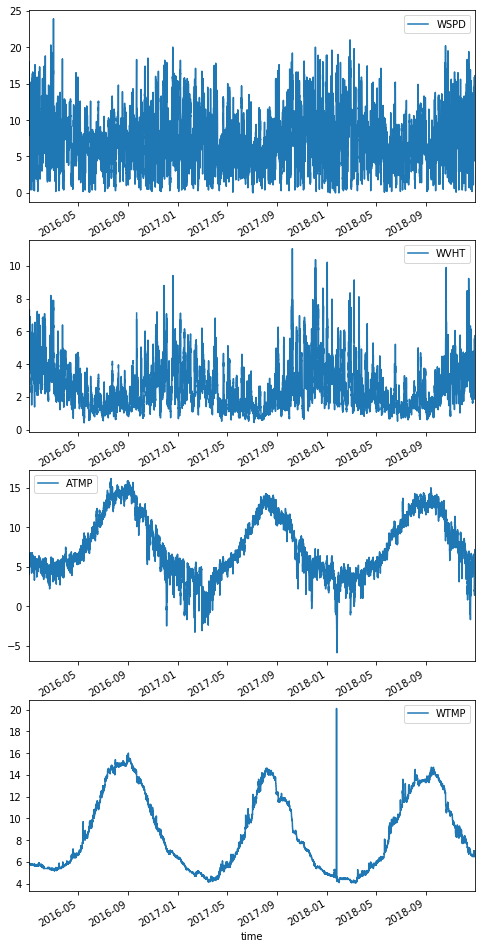

In [8]:
# We can plot straight from pandas just to take a look
plt.figure(figsize=(8, 18))
for i, v in enumerate(df.keys()):
    plt.subplot(4, 1, i+1)
    df[v].plot(label='%s' %v)
    plt.legend()

In [9]:
# Another prety handy tool that is available from pandas is to to the monthly stats as a one liner!
df_monthly = df.resample("M").mean()
df_std = df.resample("M").std()
df_n = df.resample("M").count()

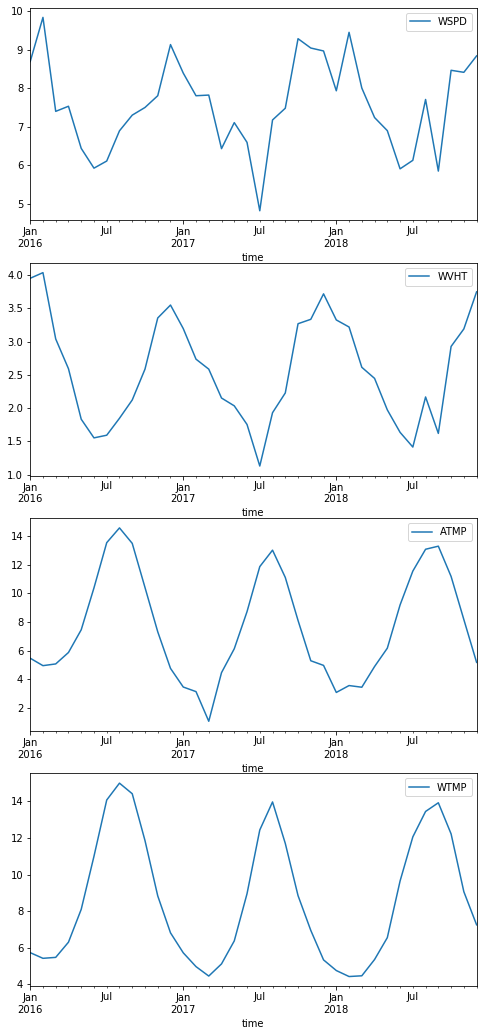

In [10]:
plt.figure(figsize=(8, 18))
for i, v in enumerate(df_monthly.keys()):
    plt.subplot(4, 1, i+1)
    df_monthly[v].plot(label='%s' %v)
    plt.legend()

In [11]:
# Just an example on how to do the fit (I'll do it for the surface temperature)
from scipy.linalg import inv

nt = len(df_monthly.index)
time = np.arange(1, nt+1) # each value is one month
WTMP = df_monthly['WTMP'].values.reshape([nt, 1])
A = np.array([np.ones(nt), time, np.sin(2*np.pi*time/12), np.cos(2*np.pi*time/12) ]).T 
x = np.dot(inv(np.dot(A.T, A)), np.dot(A.T, WTMP))
fit = np.dot(A, x)
print('Mean from fit:', x[0][0], '\nLinear trend from fit:', x[1][0],
      '\nAmplitude of sine:', x[2][0],'\nAmplitude of cosine:', x[3][0])

Mean from fit: 9.403982846920727 
Linear trend from fit: -0.041427147259154945 
Amplitude of sine: -4.408660666116586 
Amplitude of cosine: -1.7336538856004668


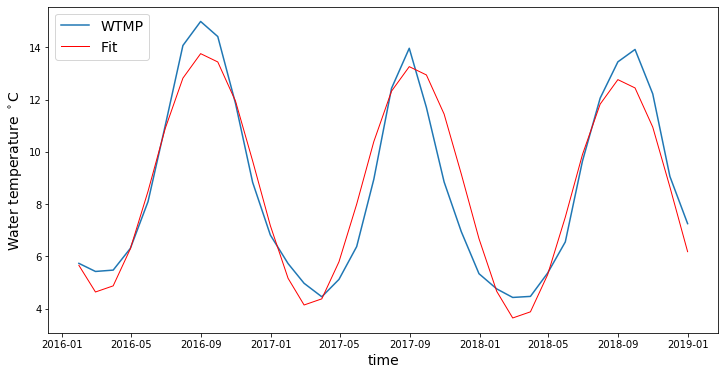

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['WTMP'], label = 'WTMP')
plt.plot(df_monthly.index, fit, 'r', lw=1, label = 'Fit')
plt.ylabel('Water temperature $^\circ$C', fontsize=14)
plt.xlabel('time', fontsize=14)
plt.legend(fontsize=14)